In [1]:
%load_ext autotime

# Examine Target

This notebook look at some of the properties for a specific target as pulled from the sources listed generated in the [Source Detection](PIAA-Source-Detection-And-Filtering.ipynb) notebook. 

Note that this step is not necessary for the processing of an observation sequence as a whole but instead serves to highlight some of the issues with processing the images in a traditional fashion and thus helps motivate our unique algorithm.

In [2]:
import os

from matplotlib import cm
from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd
from collections import defaultdict

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor
from piaa.utils import noise

from pocs.utils.images import fits as fits_utils
from pocs.utils.google.storage import PanStorage

from astropy.io import fits
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy import units as u

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

styles = plot.get_labelled_style_cycler(cmap='Paired')

time: 2.54 s


## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [3]:
# picid = 435715608
# picid = 287933433
picid = 287511722
# picid = 393243342
# picid = 343362027 # Hot pixel?
# picid = 11133916  # Same mag as HD189733
# picid = 86234511
# picid = helpers.get_star_info(twomass_id='20005694+2250490', cursor=tess_cursor).id
# picid = 11135315

star_info = helpers.get_star_info(picid=picid, cursor=tess_cursor)

time: 85.8 ms


In [4]:
twomass = '20004370+2242391'

star_info = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor)
picid = star_info.id  # HD 189733

time: 45.4 ms


In [5]:
print(f'PICID: {picid}')

PICID: 256364928
time: 686 µs


#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [6]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
# base_dir = '/var/panoptes/images/fields/PAN001/Hd189733/14d3bd/20180913T085704/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

sources = pipeline.lookup_sources_for_observation(filename=source_filename).set_index(['picid'], append=True)

time: 902 ms


For our target table we want to compare the flux as calculated from `sextractor` (which has no knowledge of the RGB array) with that pulled from a custom stamp.  `sextractor` uses a 6-pixel circular aperture  centered around the calculated centroid (the `x` and `y` values in our `sources` table) while our custom stamps will use an aperture that is sliced according to our rule of having a fixed pixel pattern. Here we use a 6-pixel aperture on our stamps for direct comparison with `sextractor` but the size can be vary.

In [7]:
camera_bias = 2048 * u.adu
stamp_size = 6 * u.pixel
num_pixels = (stamp_size**2).value

readout_noise = 10.5 * u.electron / u.pixel
gain = 1.5 * (u.electron / u.adu)
qe = 0.43

focal_length = 85 * u.mm
fstop = 1.4

aperture_area = focal_length / fstop
aperture_area = (np.pi * (aperture_area / 2)**2).to(u.m * u.m)

time: 2.79 ms


In [17]:
exptime = fits_utils.getval(os.path.join(base_dir, sources.iloc[0].file), 'EXPTIME')

time: 6.97 ms


In [8]:
num_sources = len(sources.index.levels[1])

time: 1.09 ms


In [9]:
counts = list()

i = 0
for pid, target_table in tqdm(sources.groupby('picid'), total=num_sources):
    i += 1
#     if i > 10:
#         break
    psc = pd.read_csv(os.path.join(base_dir, 'stamps', f'{pid}.csv'), parse_dates=True).set_index(['obs_time', 'picid'])
    
    for idx, row in psc.iterrows():
        date_obs= idx[0]
        row_info = dict(date_obs=date_obs, picid=pid)
        
        stamp_counts = row.values.reshape(10, 10) - camera_bias.value
        stamp_electrons = stamp_counts * gain.value

        # Store the overall flux
        row_info['counts_raw'] = int(stamp_counts.sum())
        row_info['elec_raw'] = stamp_electrons.sum()
        
        back_mean, back_median, back_std = sigma_clipped_stats(stamp_electrons)
        row_info['elec_back_mean'] = back_mean
        row_info['elec_back_std'] = back_std
        
        stamp_elec_calib = (stamp_electrons - back_mean).sum()
        row_info['elec'] = stamp_elec_calib
        
        if stamp_elec_calib <=0:
            continue
        
        # Photon noise
        elec_noise = int(np.sqrt(stamp_elec_calib))
        row_info[f'elec_noise'] = elec_noise

        # Readout noise
        readout = ((readout_noise) * (stamp_size**2)).value
        row_info[f'readout_noise'] = readout        
        
        color_data = helpers.get_rgb_data(stamp_electrons, force_new=True)

        # Calculate some properties for each channel
        for color, color_electrons in zip('rgb', color_data):
            # Background noise
            back_mean, back_med, back_std = sigma_clipped_stats(color_electrons)
            row_info[f'{color}_elec_back_mean'] = back_mean
            row_info[f'{color}_elec_back_std'] = back_std
            
            stamp_sum = (color_electrons - back_mean).sum()
            
            if stamp_sum <= 0:
#                 print(f'Negative stamp: {pid} {color} {date_obs} {stamp_sum}')
                continue
                
            row_info[f'{color}_elec_raw'] = color_electrons.sum()
            row_info[f'{color}_elec'] = stamp_sum

            # Photon noise
            count_noise = int(np.sqrt(stamp_sum))
            row_info[f'{color}_elec_noise'] = count_noise

            # Readout noise
            readout = ((readout_noise) * (color_electrons.count() * u.pixel)).value
            row_info[f'{color}_readout_noise'] = readout
            
            # Dark noise (see Zhang et al 2016)
            dark_noise = 0.1 * exptime
            row_info[f'{color}_dark'] = dark_noise
            
        counts.append(row_info)

df1 = pd.DataFrame(counts).set_index(['date_obs'])
df1.index = pd.to_datetime(df1.index)
df1.to_csv(os.path.join(base_dir, f'point-sources-noise.csv'))


time: 45min 21s


In [26]:
(color_electrons).sum()

27181.5

time: 3.13 ms


In [19]:
target_noise = df1.loc[df1.picid == picid]

time: 4.51 ms


In [27]:
target_noise.tail()

,b_elec,b_elec_back_mean,b_elec_back_std,b_elec_noise,b_elec_raw,b_readout_noise,counts_raw,elec,elec_back_mean,elec_back_std,...,g_elec_raw,g_readout_noise,picid,r_elec,r_elec_back_mean,r_elec_back_std,r_elec_noise,r_elec_raw,r_readout_noise,readout_noise
date_obs,,,,,,,,,,,,,,,,,,,,,
2018-08-22 07:34:51,8170.500000,1574.700000,97.917491,90.0,47538.0,262.5,169555,23854.308511,2304.781915,716.753944,...,159774.0,525.0,256364928,4973.217391,1681.891304,218.643345,70.0,47020.5,262.5,378.0 electron / pix
2018-08-22 07:36:46,7290.642857,1549.714286,122.264601,85.0,46033.5,262.5,168457,20066.750000,2326.187500,772.717443,...,158970.0,525.0,256364928,6840.928571,1633.642857,133.244060,82.0,47682.0,262.5,378.0 electron / pix
2018-08-22 07:40:32,7026.500000,1579.000000,135.635278,83.0,46501.5,262.5,165752,26404.595745,2222.234043,690.852979,...,156475.5,525.0,256364928,7681.357143,1518.785714,146.424251,87.0,45651.0,262.5,378.0 electron / pix
2018-08-22 07:42:20,9092.131579,1504.894737,85.035222,95.0,46714.5,262.5,166044,26793.419355,2222.725806,680.108979,...,156288.0,525.0,256364928,6531.000000,1581.300000,120.949308,80.0,46063.5,262.5,378.0 electron / pix
2018-08-22 07:44:07,7299.642857,1575.214286,148.865197,85.0,46680.0,262.5,166078,20924.812500,2281.921875,774.480886,...,157177.5,525.0,256364928,7193.428571,1522.642857,125.168091,84.0,45259.5,262.5,378.0 electron / pix


time: 36.1 ms


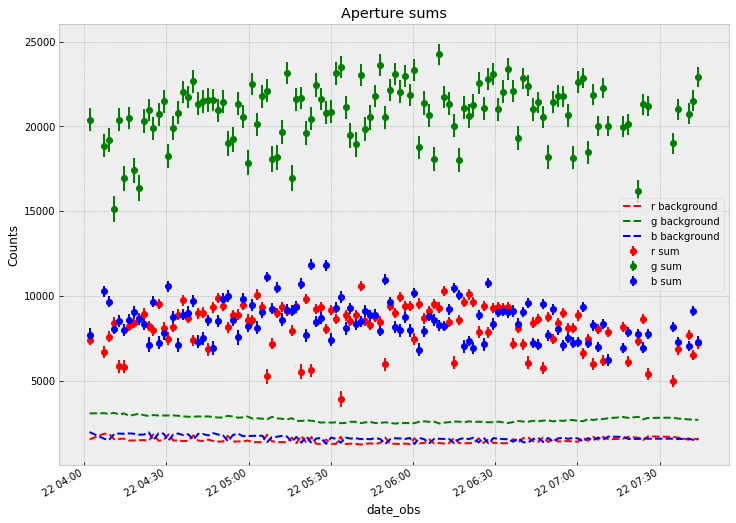

time: 771 ms


In [29]:
plt.figure(figsize=(12, 9))
for color in 'rgb':
    color_err = np.sqrt(target_noise[f'{color}_elec_back_std']**2 + target_noise[f'{color}_readout_noise']**2 + target_noise[f'{color}_elec_noise']**2)

#     plt.figure(figsize=(12, 9))
    target_noise[f'{color}_elec'].plot(ls='', marker='o', yerr=color_err, color=color, label=f'{color} sum')
    target_noise[f'{color}_elec_back_mean'].plot(color=color, ls='--', label=f'{color} background')

plt.ylabel('Counts')
plt.title('Aperture sums')
plt.legend()